In [1]:
import json
import imp
import random
import sys

from matplotlib import pyplot as plt
from matplotlib import cm
import mpld3
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.core import display

sys.path.append("/Users/awaw/me/plant/code")
import main as plant
from agent import simple


def softmax(x):
    maxes = np.amax(x, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    ex = np.exp(x - maxes)
    sumex = np.sum(ex, axis=1)
    sumex = sumex.reshape(sumex.shape[0], 1)
    dist = ex / sumex
    return dist


def interpolate_df(df, col, target_values):
    # Create support for interpolation
    df = df.set_index(col, drop=False)
    new_index = np.unique(np.concatenate((target_values, df.index)))
    # Avoid interpolation on some columns
    fixed_cols = df.columns[np.where(df.apply(lambda col: col.nunique()) == 1)]
    fixed_col_dict = dict(df[fixed_cols].iloc[0])
    df = df.reindex(new_index)
    df.loc[:, fixed_cols] = df.loc[:, fixed_cols].fillna(fixed_col_dict)

    # Interpolate
    df = df.interpolate(method='linear', limit=10000, limit_direction='both')
    # Rebuild the index
    df = (df.reindex(target_values)
          .reset_index(drop=True))
    df[col] = target_values
    return df


def interpolate_df_time(df, plot_unit, plot_time, num_interpolation_bins):
    time_min = df[plot_time].min()
    time_max = df[plot_time].max()
    
    if time_min != time_max:
        time_range = np.linspace(time_min, time_max, num_interpolation_bins)
    else:
        # We cannot interpolation if time_min == time_max, since that would cause
        # multiple rows with the same time, which is the x axis.
        # tsplot would throw errors if there duplicate rows on the x axis.
        #
        # However, if we do not interpolate at all, there would be only a single
        # time value on the x axis, and neither can tsplot work in this case.
        #
        # As an expedient, add a virtual time step with the same value by
        # interpolate at time_max+1.
        time_range = np.linspace(time_min, time_max+1, 2)
        
    norm_df = df.groupby([plot_unit]).apply(
        interpolate_df, col=plot_time, target_values=time_range)
    norm_df.reset_index(drop=True, inplace=True)
    return norm_df


def interpolate_df_cols(df, plot_unit, plot_time, cols, num_interpolation_bins):
    df_list = [df[plot_unit], df[plot_time]]
    for col in cols:
        if col == plot_unit or col == plot_time:
            continue
        df_list.append(df[col])
    
    sub_df = pd.concat(df_list, axis=1)
    res_df = interpolate_df_time(sub_df, plot_unit, plot_time, num_interpolation_bins)
    return res_df

In [2]:
def load_df(exp_dir):
    with open(exp_dir + "/log") as f:
        lines = f.readlines()
    logs = [json.loads(l) for l in lines]
    df = pd.DataFrame(logs)
    return df


def load_df_from_dirs(dirs):
    all_df = pd.DataFrame()
    for edir in dirs:
        df = load_df(edir)
        all_df = all_df.append(df)
    return all_df


all_df = pd.DataFrame()


no_len_cm_exp_dirs = [
    "/tmp/plant/no_len_cm_1507701074",
    "/tmp/plant/no_len_cm_1507701080",
]
df = load_df_from_dirs(no_len_cm_exp_dirs)
df["has_len_cm"] = False
all_df = all_df.append(df)


exp_dirs = [
    "/tmp/plant/1507700891",
    "/tmp/plant/1507700903",
    "/tmp/plant/1507749547",
]
df = load_df_from_dirs(exp_dirs)
df["has_len_cm"] = True
all_df = all_df.append(df)

In [3]:
def plot(df, ax, plot_time, plot_value, label, color):
    mean_df = df.groupby(plot_time).mean()
    ax.plot(mean_df.index, mean_df[plot_value], label=label, color=color)

    std_df = df.groupby(plot_time).std()
    ax.fill_between(
        std_df.index,
        mean_df[plot_value] - std_df[plot_value], mean_df[plot_value] + std_df[plot_value],
        color=color, alpha=.4)

    
def plot_by_values(df, plot_unit, plot_time, plot_val_cols, y_label):
    num_interpolation_bins = 128
    df = interpolate_df_cols(df, plot_unit, plot_time, plot_val_cols, num_interpolation_bins)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    fig.subplots_adjust(right=0.5)
    
    colors=cm.rainbow(np.linspace(0, 1, len(plot_val_cols)))
    for i, pvc in enumerate(plot_val_cols):
        sub_df = pd.concat([df[plot_time], df[pvc], df[plot_unit]], axis=1)  
        plot(sub_df, ax, plot_time, pvc, pvc, colors[i])

    handles, labels = ax.get_legend_handles_labels() # return lines and labels
    start_visible = True
    interactive_legend = mpld3.plugins.InteractiveLegendPlugin(zip(handles, ax.collections),
                                                               labels,
                                                               alpha_unsel=0.0,
                                                               alpha_over=1.5, 
                                                               start_visible=start_visible)

    mpld3.plugins.connect(fig, interactive_legend)
    ax.set_xlabel(plot_time, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    display.display(display.HTML(mpld3.fig_to_html(fig)))


def plot_by_condition(df, plot_unit, plot_time, plot_value, plot_cond, score_func, max_plots):
    cols = [plot_value, plot_cond]
    num_interpolation_bins = 128
    df = interpolate_df_cols(df, plot_unit, plot_time, cols, num_interpolation_bins)
    
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    fig.subplots_adjust(right=0.5)

    cond_vals = df[plot_cond].unique()
    cond_scores = []
    for condv in cond_vals:
        sub_df = df[df[plot_cond] == condv]
        score = score_func(condv, sub_df)
        cond_scores.append({"cond": condv,"score": score, "df": sub_df})
    cond_scores = sorted(cond_scores, key=lambda x: x["score"], reverse=True)
    if max_plots > 0 and len(cond_scores) > max_plots:
        cond_scores = cond_scores[:max_plots]
    
    colors=cm.rainbow(np.linspace(0, 1, len(cond_scores)))
    for i, cond in enumerate(cond_scores):
        sub_df = cond["df"]
        label = "{}: {}".format(cond["cond"], cond["score"])

        sub_df = pd.concat([sub_df[plot_time], sub_df[plot_value], sub_df[plot_unit]], axis=1)
        plot(sub_df, ax, plot_time, plot_value, label, colors[i])
        
    handles, labels = ax.get_legend_handles_labels() # return lines and labels
    start_visible = True
    interactive_legend = mpld3.plugins.InteractiveLegendPlugin(zip(handles, ax.collections),
                                                               labels,
                                                               alpha_unsel=0.0,
                                                               alpha_over=1.5, 
                                                               start_visible=start_visible)

    mpld3.plugins.connect(fig, interactive_legend)
    ax.set_xlabel(plot_time, fontsize=16)
    ax.set_ylabel(plot_value, fontsize=16)
    display.display(display.HTML(mpld3.fig_to_html(fig)))
    

def score_by_latest(cond, df):
    values = df.tail(8)[plot_value].values
    if len(values) == 0:
        return 0
      
    score = sum(values)/float(len(values))
    return score

    
plot_unit = "wid"
plot_time = "step"

display.display(display.HTML("""<h3>Best agents</h3>"""))
df = all_df
plot_value = "eval_correct_percentage"
plot_cond = "wid"
max_plots = -1
plot_by_condition(df, plot_unit, plot_time, plot_value, plot_cond, score_by_latest, max_plots)

display.display(display.HTML("""<h3>Generalization has_len_cm=True</h3>"""))
df = all_df[all_df["has_len_cm"] == True]
plot_val_cols = ["train_correct_percentage", "eval_correct_percentage"]
plot_by_values(df, plot_unit, plot_time, plot_val_cols, "Accuracy")

display.display(display.HTML("""<h3>has_len_cm comparison</h3>"""))
df = all_df
plot_value = "eval_correct_percentage"
plot_cond = "has_len_cm"
plot_by_condition(df, plot_unit, plot_time, plot_value, plot_cond, score_by_latest, max_plots)

INFO:tensorflow:Restoring parameters from /tmp/plant/no_len_cm_1507701074/checkpoint/a-915
--------------


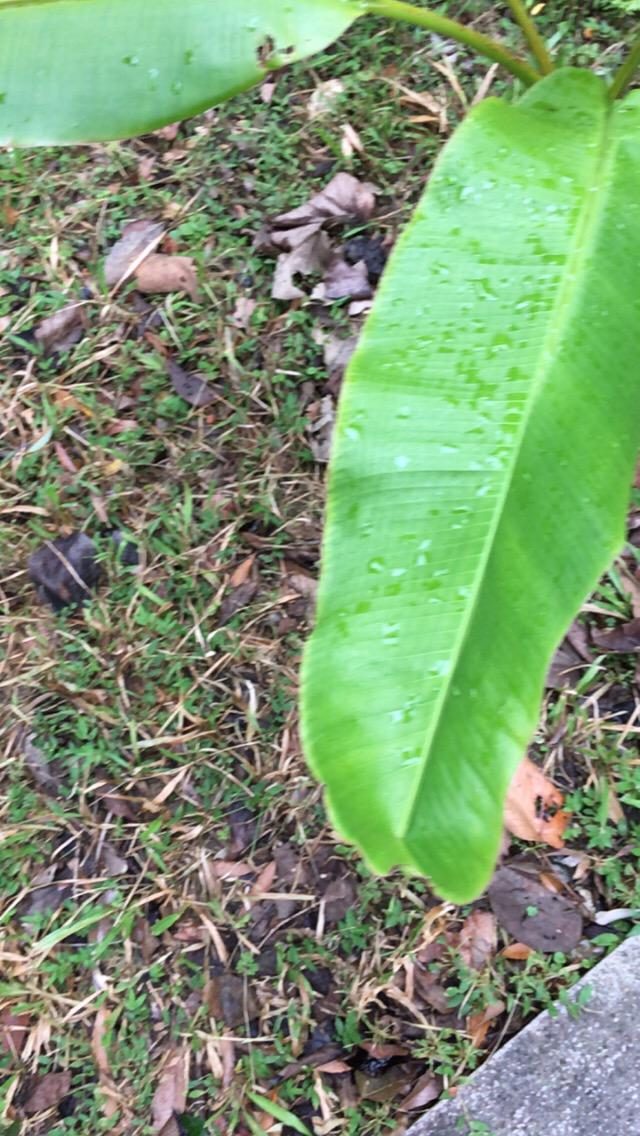

file: 1XGtMgjEP.jpg
label: 台灣芭蕉
prediction: 台灣芭蕉
probability: [ 0.11792283  0.15052278  0.08764203  0.22585908  0.41805333]



--------------


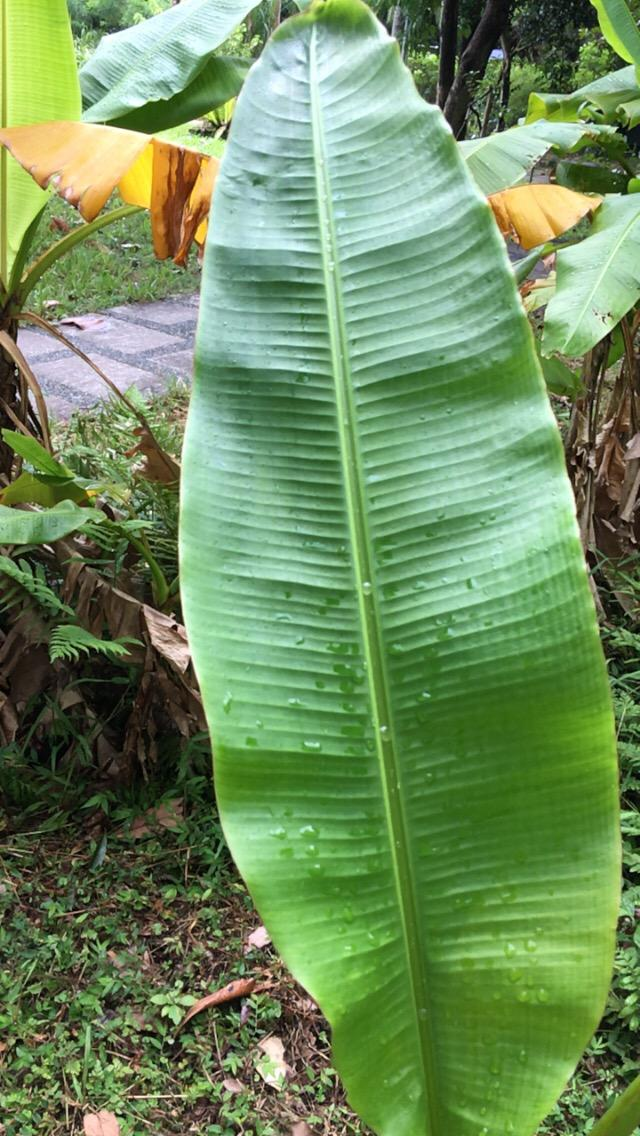

file: 85g8l0wAk.jpg
label: 台灣芭蕉
prediction: 台灣芭蕉
probability: [ 0.12469783  0.19353934  0.12370674  0.24204411  0.31601194]



--------------


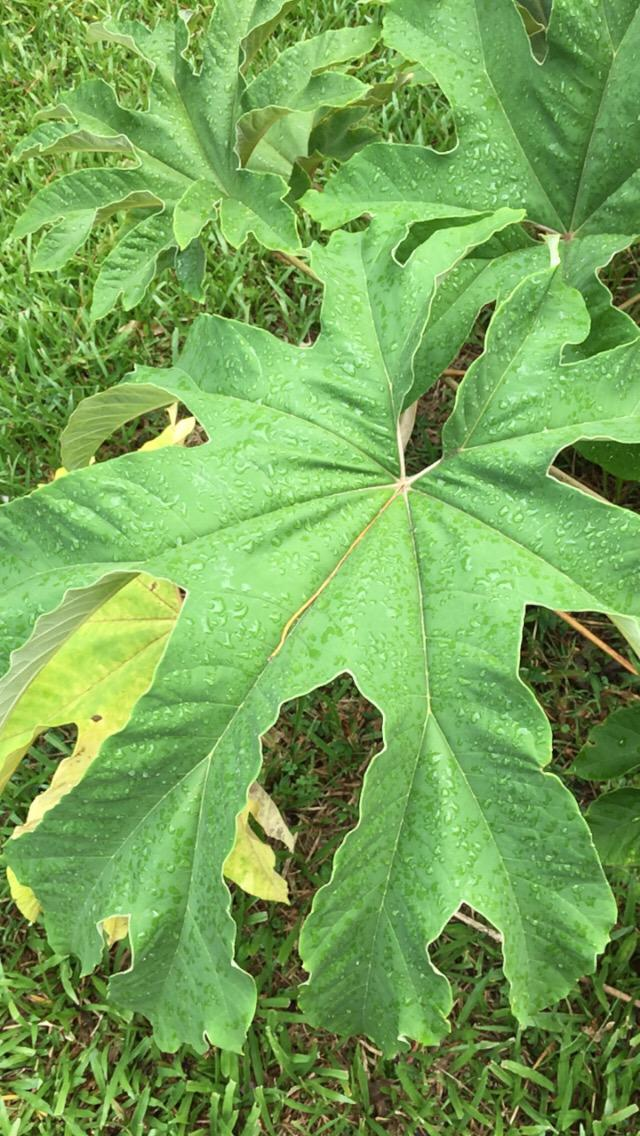

file: aAclXhLGK.jpg
label: 蓪草
prediction: 蓪草
probability: [ 0.04401698  0.15838361  0.62436569  0.09099142  0.0822423 ]



--------------


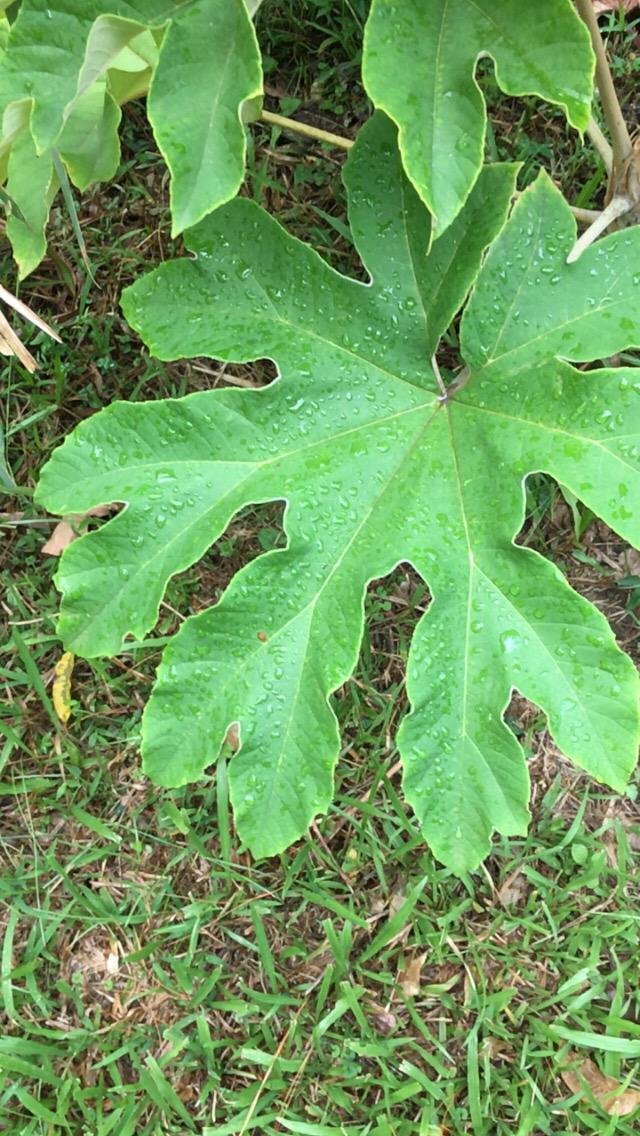

file: co0CxcWc3.jpg
label: 蓪草
prediction: 蓪草
probability: [ 0.11791518  0.13757397  0.28088149  0.227772    0.2358574 ]



--------------


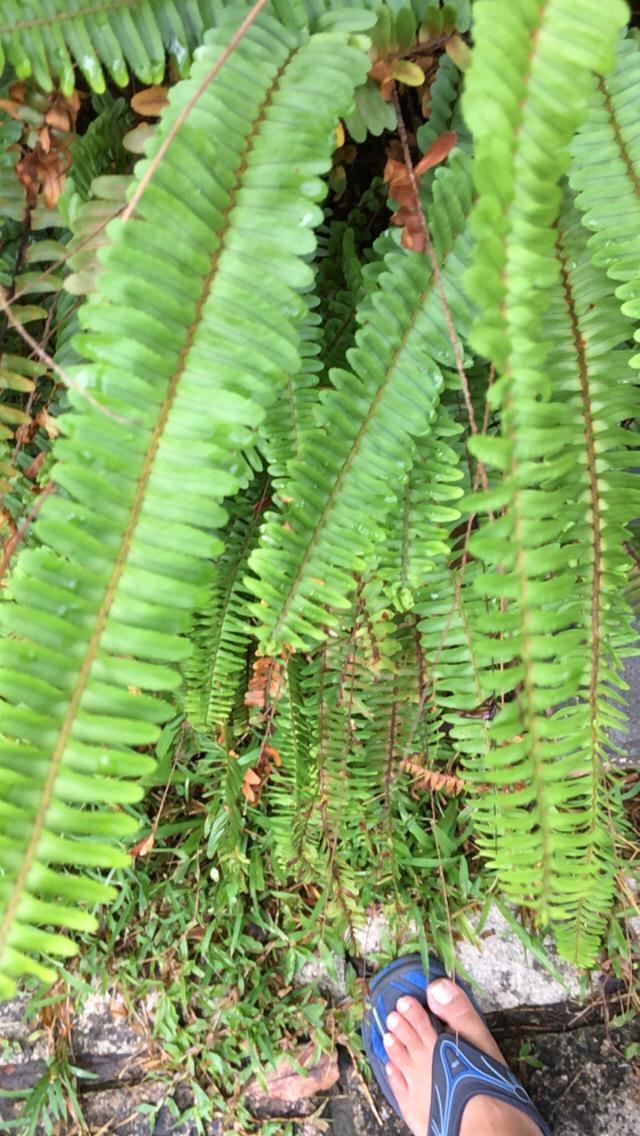

file: d3DUYtxLc.jpg
label: 腎蕨
prediction: 蓪草
probability: [ 0.13242336  0.22708125  0.40319359  0.07230088  0.16500095]



--------------


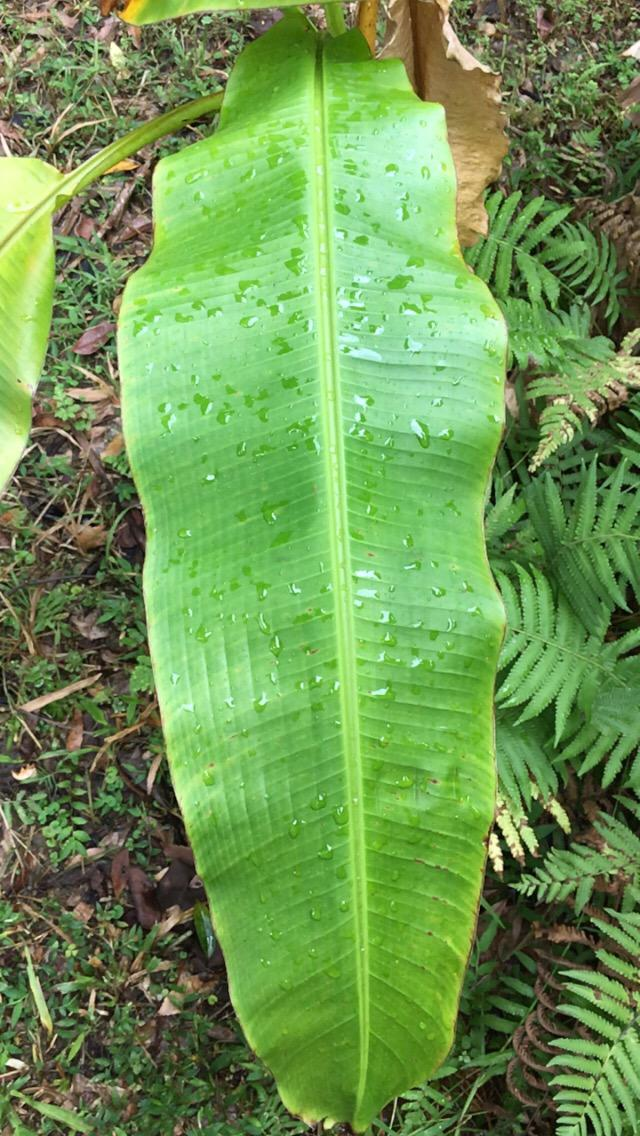

file: IblWBDOTP.jpg
label: 台灣芭蕉
prediction: 腎蕨
probability: [ 0.08101632  0.33936816  0.16375084  0.14253916  0.2733255 ]



--------------


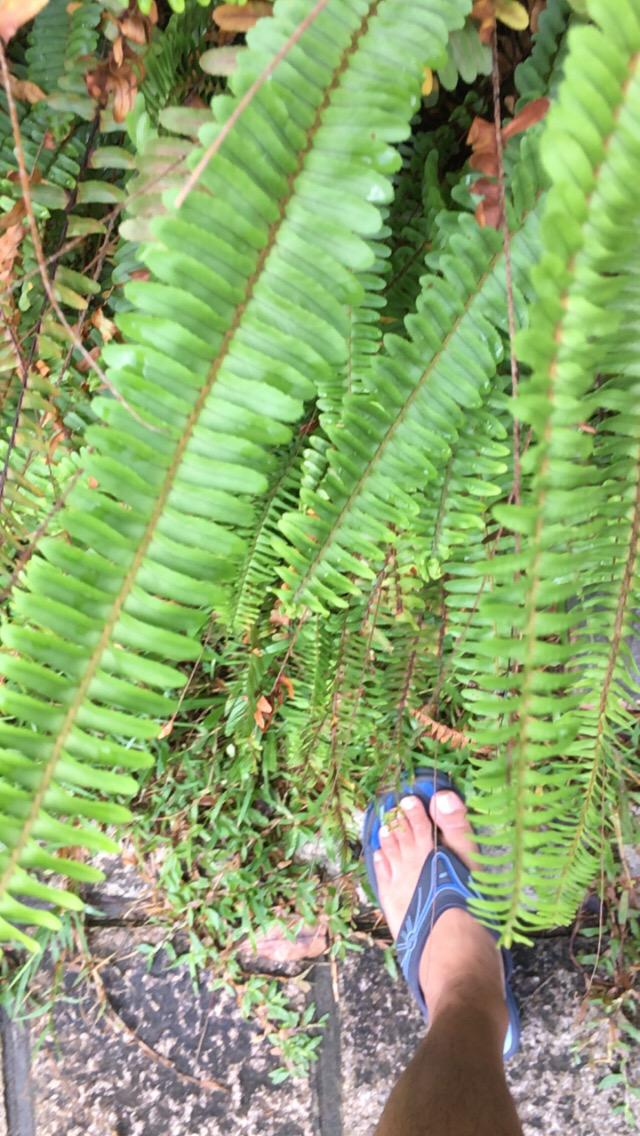

file: N8ccNXKCX.jpg
label: 腎蕨
prediction: 腎蕨
probability: [ 0.09400417  0.49660301  0.10294346  0.11120534  0.19524413]



--------------


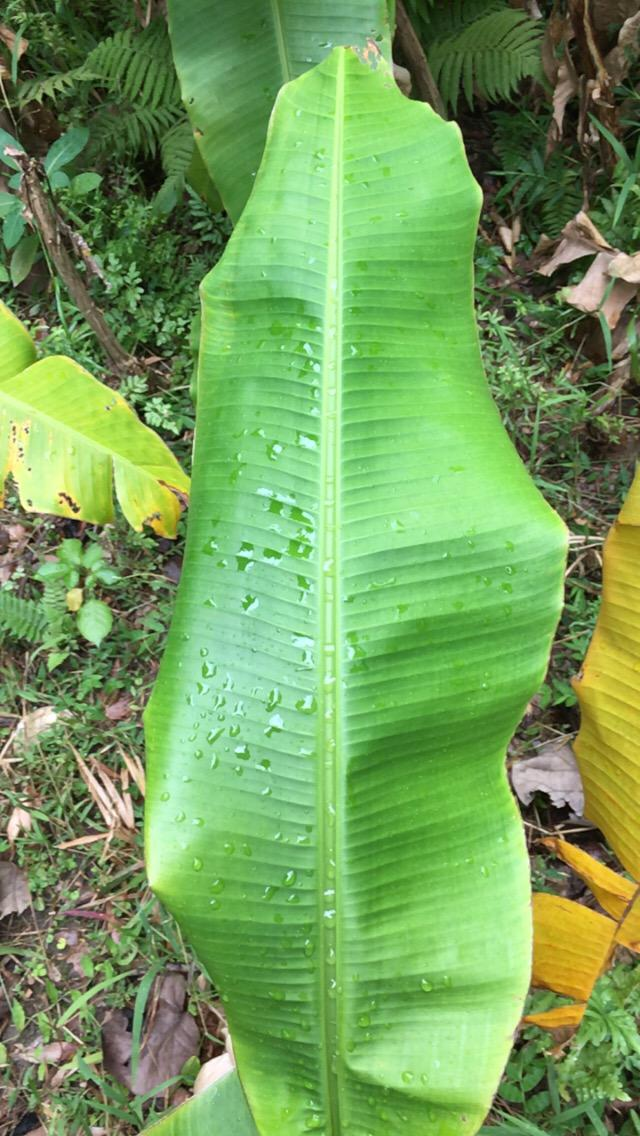

file: veoWVx2PL.jpg
label: 台灣芭蕉
prediction: 台灣芭蕉
probability: [ 0.09736658  0.11460057  0.11460557  0.08776784  0.5856595 ]



--------------


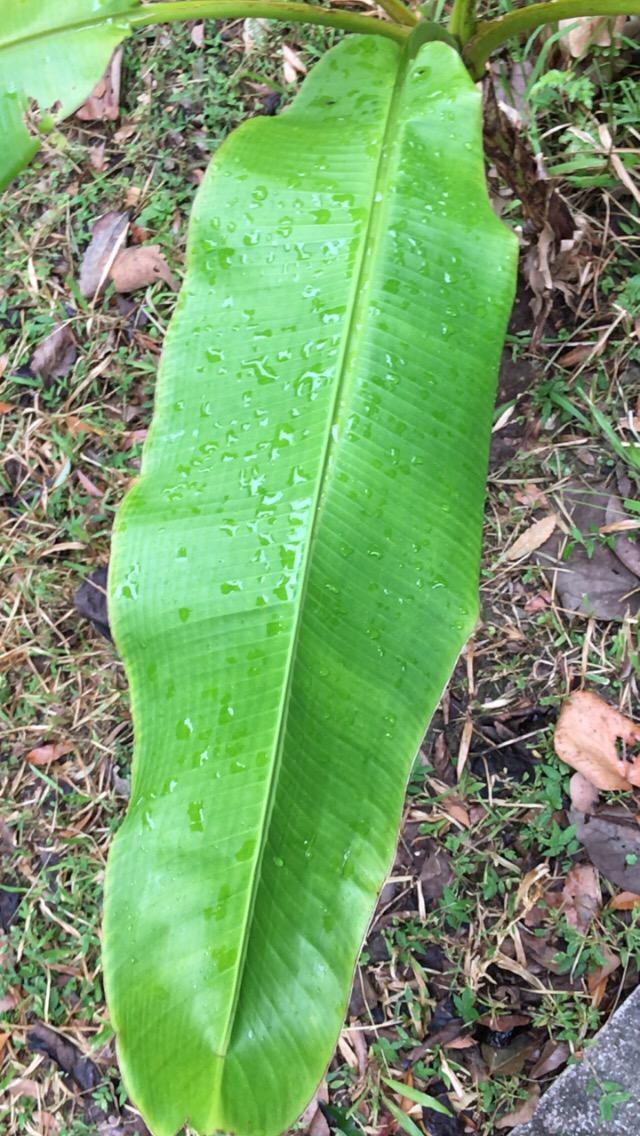

file: XGsBd5rqT.jpg
label: 台灣芭蕉
prediction: 台灣芭蕉
probability: [ 0.14407527  0.1083963   0.07205596  0.24516584  0.43030661]



--------------


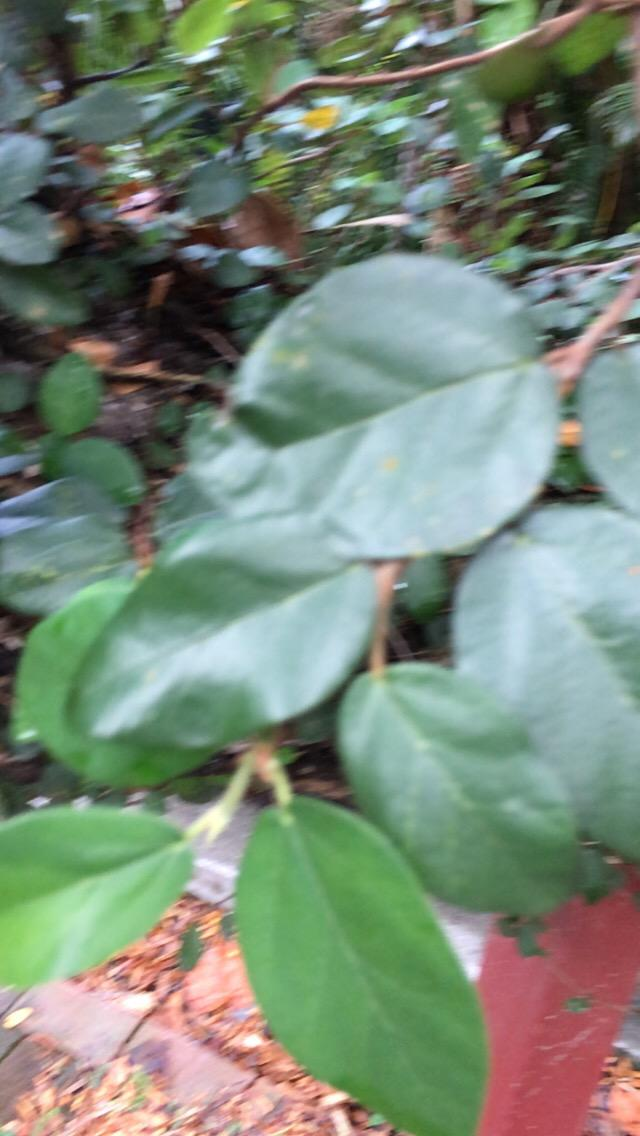

file: z2LARU6nS.jpg
label: 薜荔
prediction: 薜荔
probability: [ 0.42341781  0.11679751  0.08593533  0.24167101  0.13217837]





In [4]:
plant_names = [
    "薜荔",
    "腎蕨",
    "蓪草",
    "麻竹",
    "台灣芭蕉",
]

tf.reset_default_graph()

data_dir = "/Users/awaw/me/plant/data"
batch_size = 10
env = plant.Data(data_dir, "test", batch_size)

agent = simple.Agent(env)

saver = tf.train.Saver()

var_init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run([var_init_op])
    agent.session = sess
    
    plant.saver_restore(saver, "/tmp/plant/no_len_cm_1507701074/checkpoint", sess)
    
    obs = env.get()
    obs["len_cm"] = np.zeros(obs["len_cm"].shape)
    test_res = agent.test(obs)
    logits = test_res["logits"]
    
    pred = np.argmax(logits, axis=1)

probs = softmax(logits)
for b, name in enumerate(obs["name"]):
    print("--------------")
    
    img_src = data_dir+"/"+name
    display.display(display.Image(filename=img_src, width=100, height=100))
    
    print("file: {}".format(obs["name"][b]))
    print("label: {}".format(plant_names[obs["label"][b]]))
    print("prediction: {}".format(plant_names[pred[b]]))
    print("probability: {}".format(probs[b]))
    print("\n\n")